Training Set
Dataset/Training/image/AP25_Forest_IMAGE Done./
Dataset/Training/image/AP25_Forest_SH Done./
Dataset/Training/label/AP25_Forest_Carbon Done./
Dataset/Training/label/AP25_Forest_GT Done./
Training Set
Dataset/Training/image/SN10_Forest_IMAGE Done./
Dataset/Training/image/SN10_Forest_SH Done./
Dataset/Training/label/SN10_Forest_Carbon Done./
Dataset/Training/label/SN10_Forest_GT Done./


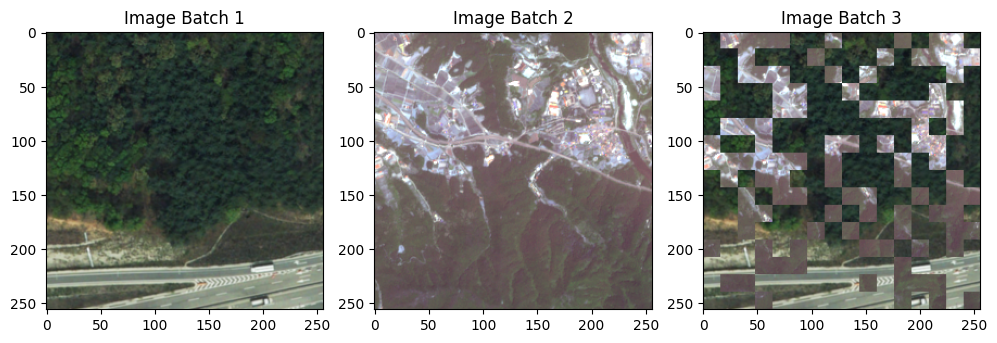

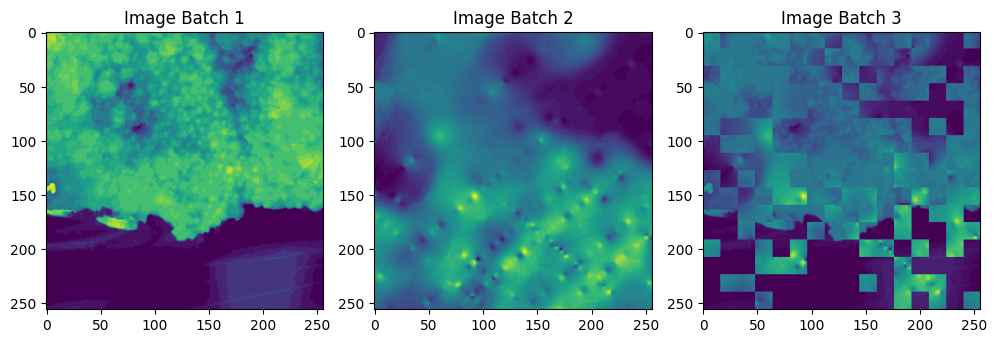

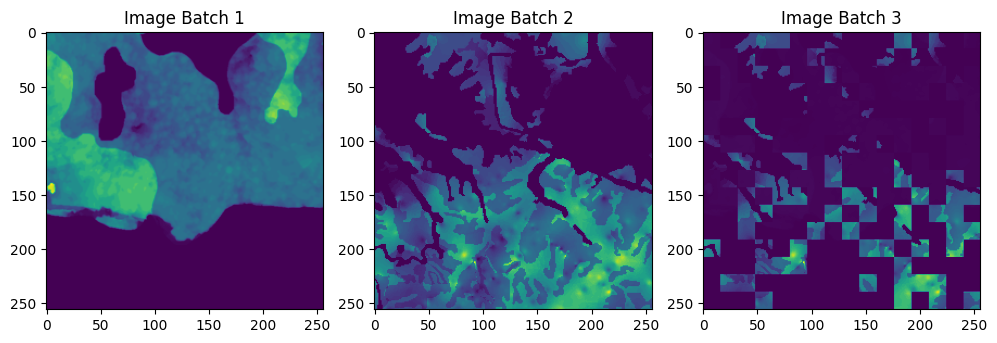

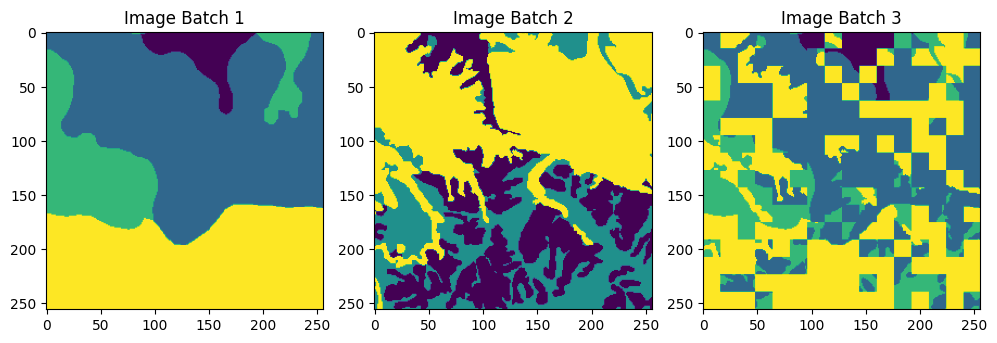

In [2]:
from dataset import CarbonDataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import torch.utils.data as data
from torch.utils.data.sampler import WeightedRandomSampler
from torch import nn

def mix_patch(batch,random_index,dataset_num=2,kernel_size=4):
    w = batch.size(2)
    h = batch.size(3)
    unfold = nn.Unfold(kernel_size=kernel_size, stride=kernel_size)
    batch = unfold(batch)
    new = batch[:batch.size(0)//dataset_num]
    for i in range(batch.size(0)//dataset_num):
        
        for j in random_index:
            new[i, :, j] = batch[i+batch.size(0)//dataset_num, :, j]
    fold = nn.Fold(output_size=(w, h), kernel_size=kernel_size, stride=kernel_size)
    return fold(new)

fp = "Dataset/Training/image/AP25_Forest_IMAGE"

label_size = 256//2
label_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 라벨 크기 조정
])
    
# 데이터셋을 위한 변환 정의
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
sh_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 데이터셋 및 데이터 로더 생성
dataset1 = CarbonDataset(fp, image_transform, sh_transform, label_transform,mode="Train")
dataset2 = CarbonDataset("Dataset/Training/image/SN10_Forest_IMAGE", image_transform,sh_transform, label_transform,mode="Train")
# 데이터 크기 기반 샘플링 비율 계산
num_samples1 = len(dataset1)
num_samples2 = len(dataset2)
sample_ratio = num_samples2 / num_samples1



# WeightedRandomSampler 사용
sampler1 = torch.utils.data.sampler.SequentialSampler(dataset1)
sampler2 = WeightedRandomSampler(weights=[1.0] * num_samples2, num_samples=int(num_samples1 * sample_ratio))
# Resize할 크기 지정
resize = transforms.Resize((256//2, 256//2))
dataloader1 = DataLoader(dataset1, batch_size=1, num_workers=8,pin_memory=True,sampler=sampler1)
dataloader2 = DataLoader(dataset2, batch_size=1, num_workers=8,pin_memory=True,sampler=sampler2)
from matplotlib import pyplot as plt
import torch
for batch1, batch2 in zip(dataloader1, dataloader2):
    image1, sh1 , carbon1 , gt1 = batch1
    image2, sh2 , carbon2 , gt2 = batch2
    x = torch.cat((image1,image2),dim=0)
    random_index = torch.randint(1, x.size(2), (x.size(2)//2,))
    new = mix_patch(x,random_index,dataset_num=2,kernel_size=16)
    x = torch.cat((x,new),dim=0)
    
    sh = torch.cat((sh1,sh2),dim=0)
    new = mix_patch(sh,random_index,dataset_num=2,kernel_size=16)
    sh = torch.cat((sh,new),dim=0)
    
    carbon = torch.cat((carbon1,carbon2),dim=0)
    new = mix_patch(carbon,random_index,dataset_num=2,kernel_size=16)
    carbon = torch.cat((carbon,new),dim=0)
    
    gt = torch.cat((gt1,gt2),dim=0)
    new = mix_patch(gt,random_index,dataset_num=2,kernel_size=16)
    gt = torch.cat((gt,new),dim=0)
    
    new = None
    
    
    list1 = [x,sh,carbon,gt]
    for i in list1:
        
        
        # 이미지를 시각화할 subplot 생성
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
        new = resize(i)
        # 첫 번째 subplot에 이미지 배치
        axes[0].imshow(i[0].permute(1, 2, 0))
        axes[0].set_title('Image Batch 1')

        # 두 번째 subplot에 이미지 배치
        axes[1].imshow(i[1].permute(1, 2, 0))
        axes[1].set_title('Image Batch 2')

        # 두 번째 subplot에 이미지 배치
        axes[2].imshow(i[2].permute(1, 2, 0))
        axes[2].set_title('Image Batch 3')
        
        # subplot 간 간격 조정
        plt.tight_layout()

        # 시각화 결과 출력
        plt.show()



    
    break

In [3]:
import torch.nn.functional as F
import torch
import torch.nn as nn



image_batch1 = torch.rand(3, 256, 256)  # 첫 번째 이미지 배치 (2개의 이미지, 3 채널, 256x256)
image_batch2 = torch.ones(3, 256, 256)  # 두 번째 이미지 배치 (2개의 이미지, 3 채널, 256x256)
print(image_batch1.dim())  # 결과: torch.Size([2, 3, 256, 256])
cat_batch = torch.cat((image_batch1, image_batch2), dim=0)
kernel_size = 16
unfold = nn.Unfold(kernel_size=kernel_size, stride=kernel_size)

unfolded1 = unfold(image_batch1)
# unfolded2 = unfold(image_batch2)
print(unfolded1.size())  # 결과: torch.Size([2, 48, 4096])
print(unfolded1[1,:].size())
# print(unfolded2.size())  # 결과: torch.Size([2, 48, 4096])

random_index = torch.randint(1, image_batch1.size(1), (image_batch1.size(1)//2,))

def mix_patch(batch,random_index,dataset_num=2,kernel_size=4):
    w = batch.size(2)
    print(batch.size())
    unfold = nn.Unfold(kernel_size=kernel_size, stride=kernel_size)
    batch = unfold(batch)
    print(batch.size())
    new = batch[:dataset_num]
    
        
    for j in random_index:
        new[j] = batch[j]
    fold = nn.Fold(output_size=(w, w), kernel_size=kernel_size, stride=kernel_size)
    return fold(new)

new = mix_patch(image_batch1,random_index=random_index,kernel_size=16)


import matplotlib.pyplot as plt

# 이미지를 시각화할 subplot 생성
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# 첫 번째 subplot에 이미지 배치
axes[0].imshow(new[0].permute(1, 2, 0))
axes[0].set_title('Image Batch 1')

# 두 번째 subplot에 이미지 배치
axes[1].imshow(new[1].permute(1, 2, 0))
axes[1].set_title('Image Batch 2')

# subplot 간 간격 조정
plt.tight_layout()

# 시각화 결과 출력
plt.show()


3
torch.Size([768, 256])
torch.Size([256])
torch.Size([3, 256, 256])
torch.Size([768, 256])


IndexError: index 142 is out of bounds for dimension 0 with size 2